In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans

### Data Exploration

In [2]:
# -----------------------------
# Load dataset
# -----------------------------
df = pd.read_csv("processed_data.csv")

In [3]:
RANDOM_STATE = 42

In [4]:
# -------- AGGREGATE ENGAGEMENT METRICS PER USER --------
# Metrics: sessions frequency, session duration (sum), total traffic DL+UL, avg session duration
agg = df.groupby("MSISDN/Number").agg(
    sessions_frequency=("Bearer Id", "count"),
    total_session_duration_ms=("Dur. (ms)", "sum"),
    total_dl=("Total DL (Bytes)", "sum"),
    total_ul=("Total UL (Bytes)", "sum"),
).reset_index()


# compute total traffic and avg session duration (ms -> minutes for readability)
agg["total_traffic_bytes"] = agg["total_dl"].fillna(0) + agg["total_ul"].fillna(0)
agg["total_session_duration_min"] = agg["total_session_duration_ms"].fillna(0) / (1000 * 60)
agg["avg_session_duration_min"] = agg["total_session_duration_min"] / agg["sessions_frequency"].replace(0, np.nan)

# Fill any remaining NaNs in numeric columns with column mean
numeric_cols = agg.select_dtypes(include=[np.number]).columns.tolist()
for c in numeric_cols:
    if agg[c].isnull().any():
        agg[c].fillna(agg[c].mean(), inplace=True)

# -------- TREAT OUTLIERS USING Z-SCORE (replace outlier with column mean) --------
def treat_outliers_zscore(df_local, cols, z_thresh=3.0):
    for col in cols:
        mean = df_local[col].mean()
        std = df_local[col].std()
        if std == 0 or np.isnan(std):
            continue
        z = (df_local[col] - mean) / std
        outlier_mask = z.abs() > z_thresh
        if outlier_mask.any():
            df_local.loc[outlier_mask, col] = mean
    return df_local

agg = treat_outliers_zscore(agg, numeric_cols, z_thresh=3.0)

# Recompute any derived columns if needed (after replacement)
agg["total_traffic_bytes"] = agg["total_dl"] + agg["total_ul"]
agg["total_session_duration_min"] = agg["total_session_duration_ms"] / (1000 * 60)
agg["avg_session_duration_min"] = agg["total_session_duration_min"] / agg["sessions_frequency"].replace(0, np.nan)
agg.fillna(0, inplace=True)

C:\Users\mohan\AppData\Local\Temp\ipykernel_7204\3957866649.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.403767687354945' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_local.loc[outlier_mask, col] = mean


In [ ]:
### Task 2 : User Engagement Analysis

## TOP 10 CUSTOMERS PER ENGAGEMENT METRIC --------

In [5]:

print("\nTop 10 customers by sessions frequency:")
print(agg.nlargest(10, "sessions_frequency")[["MSISDN/Number", "sessions_frequency"]])

print("\nTop 10 customers by total session duration (minutes):")
print(agg.nlargest(10, "total_session_duration_min")[["MSISDN/Number", "total_session_duration_min"]])

print("\nTop 10 customers by total traffic (bytes):")
print(agg.nlargest(10, "total_traffic_bytes")[["MSISDN/Number", "total_traffic_bytes"]])

print("\nTop 10 customers by average session duration (minutes):")
print(agg.nlargest(10, "avg_session_duration_min")[["MSISDN/Number", "avg_session_duration_min"]])



Top 10 customers by sessions frequency:
       MSISDN/Number  sessions_frequency
35436   3.365936e+10                11.0
57241   3.366471e+10                11.0
63028   3.366646e+10                11.0
70960   3.366907e+10                11.0
86455   3.369879e+10                11.0
13936   3.362695e+10                10.0
15664   3.363004e+10                10.0
30225   3.365826e+10                10.0
30715   3.365836e+10                10.0
37470   3.365982e+10                10.0

Top 10 customers by total session duration (minutes):
       MSISDN/Number  total_session_duration_min
54138   3.366383e+10                   16.931367
47639   3.366223e+10                   16.923317
52619   3.366344e+10                   16.918950
88157   3.369934e+10                   16.915117
40672   3.366058e+10                   16.898817
87934   3.369926e+10                   16.885600
70908   3.366905e+10                   16.882717
97471   3.376226e+10                   16.876483
93736   3.37

### NORMALIZE ENGAGEMENT METRICS & KMEANS (k=3)

In [6]:

engagement_cols = ["sessions_frequency", "total_session_duration_min", "total_traffic_bytes", "avg_session_duration_min"]
X = agg[engagement_cols].values

scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X)

kmeans_3 = KMeans(n_clusters=3, random_state=RANDOM_STATE, n_init=10)
agg["engagement_cluster_k3"] = kmeans_3.fit_predict(X_norm)

# cluster centers in original (unnormalized) space for interpretation
centers_norm = kmeans_3.cluster_centers_
centers_orig = scaler.inverse_transform(centers_norm)
centers_df = pd.DataFrame(centers_orig, columns=engagement_cols)
centers_df["cluster"] = centers_df.index
print("\nKMeans (k=3) cluster centers (approx, original scale):")
print(centers_df)



KMeans (k=3) cluster centers (approx, original scale):
   sessions_frequency  total_session_duration_min  total_traffic_bytes  \
0            3.493414                    6.524307         5.488651e+09   
1            1.123225                    1.210323         1.622651e+09   
2            1.412395                    3.430219         2.031606e+09   

   avg_session_duration_min  cluster  
0                  2.112175        0  
1                  1.127183        1  
2                  2.671962        2  


### CLUSTER STATS (MIN, MAX, AVG, TOTAL) on non-normalized metrics


Cluster statistics (non-normalized metrics):
                       sessions_frequency_min  sessions_frequency_max  \
engagement_cluster_k3                                                   
0                                         1.0                    11.0   
1                                         1.0                     4.0   
2                                         1.0                     3.0   

                       sessions_frequency_mean  sessions_frequency_sum  \
engagement_cluster_k3                                                    
0                                     3.490760            28139.018838   
1                                     1.123356            73272.000000   
2                                     1.411130            47370.230141   

                       sessions_frequency_count  \
engagement_cluster_k3                             
0                                          8061   
1                                         65226   
2            

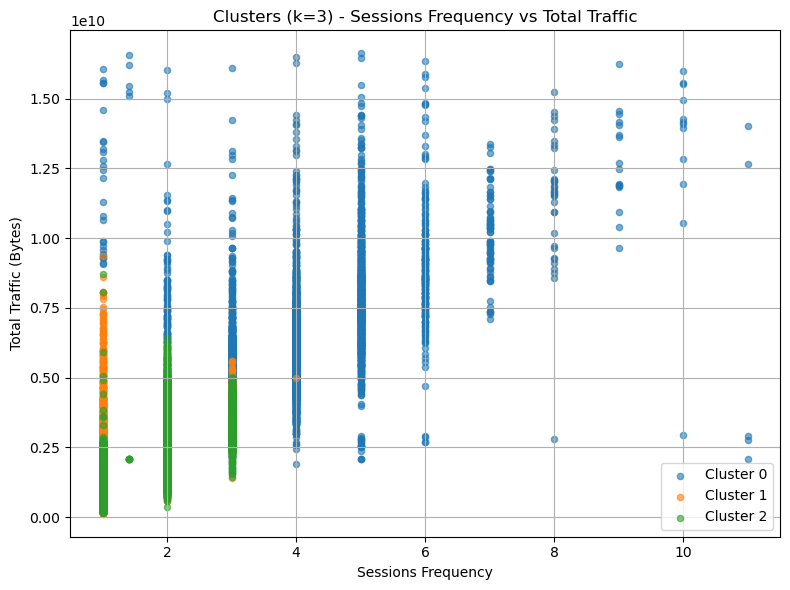

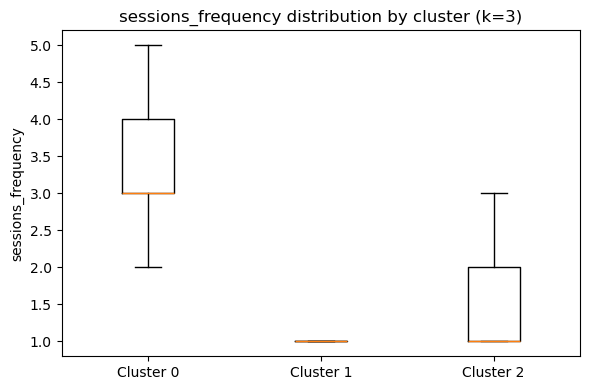

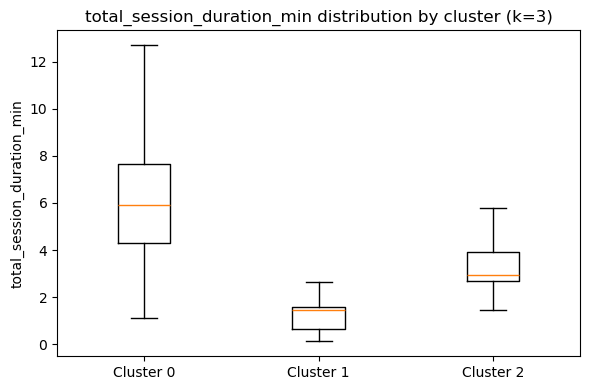

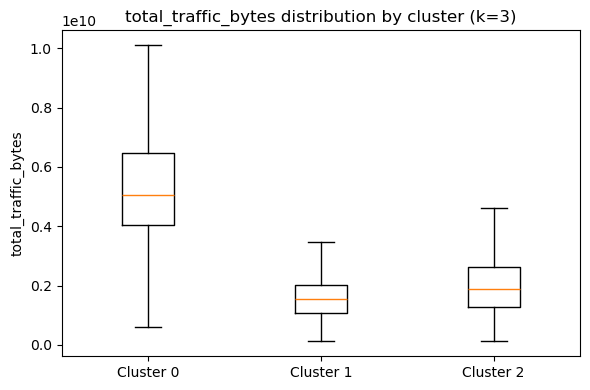

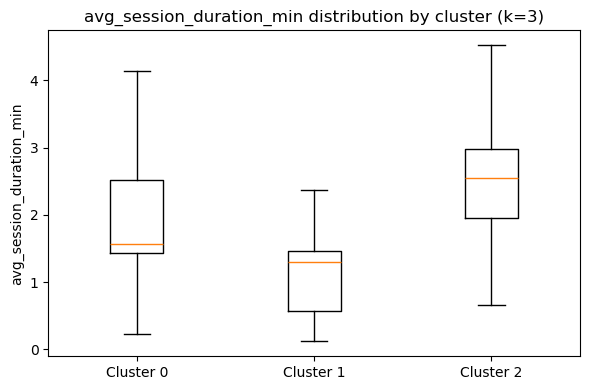


Interpretation (k=3 clusters):

Cluster 0: count=8061
 - sessions_frequency: min=1.0, mean=3.5, max=11.0
 - total_session_duration_min: mean=6.52 min
 - total_traffic_bytes: mean=5484656005 bytes

Cluster 1: count=65226
 - sessions_frequency: min=1.0, mean=1.1, max=4.0
 - total_session_duration_min: mean=1.21 min
 - total_traffic_bytes: mean=1622974739 bytes

Cluster 2: count=33569
 - sessions_frequency: min=1.0, mean=1.4, max=3.0
 - total_session_duration_min: mean=3.43 min
 - total_traffic_bytes: mean=2029346239 bytes


In [7]:
# -------- CLUSTER STATS (MIN, MAX, AVG, TOTAL) on non-normalized metrics --------
cluster_stats = agg.groupby("engagement_cluster_k3")[engagement_cols].agg(["min", "max", "mean", "sum", "count"])
# flatten columns
cluster_stats.columns = ["_".join(col).strip() for col in cluster_stats.columns.values]
print("\nCluster statistics (non-normalized metrics):")
print(cluster_stats)

# -------- VISUALIZATIONS: cluster scatter (2D) and boxplots --------
import matplotlib.colors as mcolors

plt.figure(figsize=(8,6))
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]
for cl in sorted(agg["engagement_cluster_k3"].unique()):
    mask = agg["engagement_cluster_k3"] == cl
    plt.scatter(agg.loc[mask, "sessions_frequency"], agg.loc[mask, "total_traffic_bytes"],
                s=20, alpha=0.6, label=f"Cluster {cl}", color=colors[cl % len(colors)])
plt.xlabel("Sessions Frequency")
plt.ylabel("Total Traffic (Bytes)")
plt.title("Clusters (k=3) - Sessions Frequency vs Total Traffic")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Boxplots of each metric by cluster
for col in engagement_cols:
    plt.figure(figsize=(6,4))
    data_to_plot = [agg[agg["engagement_cluster_k3"] == cl][col] for cl in sorted(agg["engagement_cluster_k3"].unique())]
    plt.boxplot(data_to_plot, labels=[f"Cluster {c}" for c in sorted(agg["engagement_cluster_k3"].unique())], showfliers=False)
    plt.title(f"{col} distribution by cluster (k=3)")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

# Print textual interpretation of cluster stats
print("\nInterpretation (k=3 clusters):")
for cl in sorted(agg["engagement_cluster_k3"].unique()):
    row = cluster_stats.loc[cl]
    print(f"\nCluster {cl}: count={int(row['sessions_frequency_count'])}")
    print(f" - sessions_frequency: min={row['sessions_frequency_min']:.1f}, mean={row['sessions_frequency_mean']:.1f}, max={row['sessions_frequency_max']:.1f}")
    print(f" - total_session_duration_min: mean={row['total_session_duration_min_mean']:.2f} min")
    print(f" - total_traffic_bytes: mean={row['total_traffic_bytes_mean']:.0f} bytes")

### AGGREGATE USER TOTAL TRAFFIC PER APPLICATION & TOP 10 USERS PER APP

In [8]:
apps = ["Social Media", "Google", "Email", "Youtube", "Netflix", "Gaming", "Other"]
# build per-user app totals
app_user_totals = agg[["MSISDN/Number"]].copy()
for app in apps:
    dl_col = f"{app} DL (Bytes)"
    ul_col = f"{app} UL (Bytes)"
    if dl_col in df.columns and ul_col in df.columns:
        # sum per user from original df (not agg)
        app_sum = df.groupby("MSISDN/Number")[[dl_col, ul_col]].sum().sum(axis=1)
        app_sum = app_sum.reset_index()
        app_sum.columns = ["MSISDN/Number", f"{app.lower().replace(' ', '_')}_bytes"]
        app_user_totals = app_user_totals.merge(app_sum, on="MSISDN/Number", how="left")
    else:
        app_user_totals[f"{app.lower().replace(' ', '_')}_bytes"] = 0

# fill NaN with 0
app_user_totals.fillna(0, inplace=True)

# Top 10 users per application
print("\nTop 10 users per application (by bytes):")
top10_per_app = {}
for app in apps:
    col = f"{app.lower().replace(' ', '_')}_bytes"
    top10 = app_user_totals.nlargest(10, col)[["MSISDN/Number", col]]
    top10_per_app[app] = top10
    print(f"\n--- {app} ---")
    print(top10.to_string(index=False))


Top 10 users per application (by bytes):

--- Social Media ---
 MSISDN/Number  social_media_bytes
  3.366371e+10        1.974199e+09
  3.362632e+10        4.337478e+07
  3.376054e+10        3.978319e+07
  3.365973e+10        3.541236e+07
  3.361489e+10        2.829454e+07
  3.362578e+10        2.713550e+07
  3.366716e+10        2.424785e+07
  3.378632e+10        2.397492e+07
  3.366907e+10        2.380083e+07
  3.360313e+10        2.307782e+07

--- Google ---
 MSISDN/Number  google_bytes
  3.366371e+10  8.250702e+09
  3.362632e+10  1.521919e+08
  3.362578e+10  1.423079e+08
  3.361489e+10  1.279738e+08
  3.376054e+10  1.232231e+08
  3.365973e+10  1.165163e+08
  3.378632e+10  1.102545e+08
  3.367588e+10  1.098605e+08
  3.366716e+10  1.050327e+08
  3.376127e+10  9.708999e+07

--- Email ---
 MSISDN/Number  email_bytes
  3.366371e+10 2.403622e+09
  3.362632e+10 4.241878e+07
  3.361489e+10 4.078863e+07
  3.362578e+10 4.063397e+07
  3.378632e+10 3.631012e+07
  3.365973e+10 3.599979e+07
  3.3

### Plot top 3 most used applications (by total traffic across all users)


Top 3 applications by total traffic (all users):
Gaming     6.454984e+13
Other      6.440468e+13
Youtube    3.396467e+12
dtype: float64


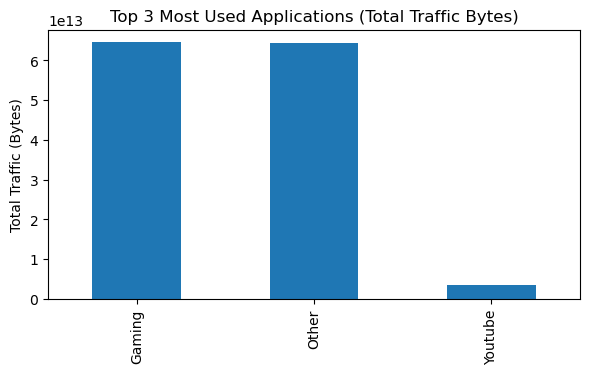

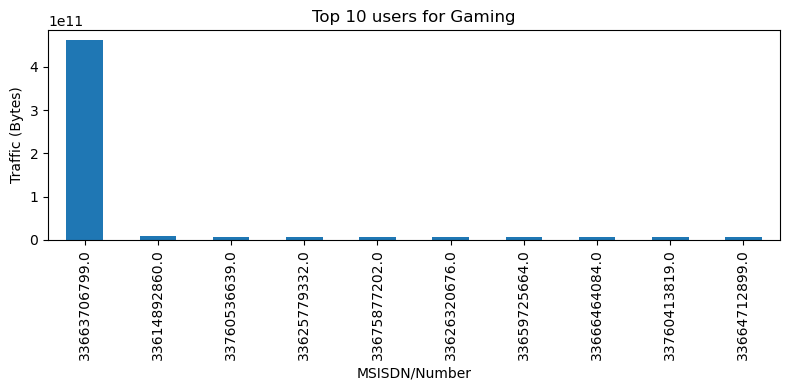

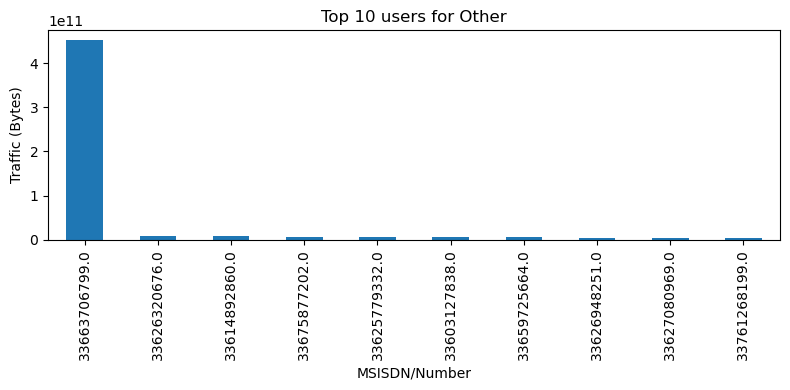

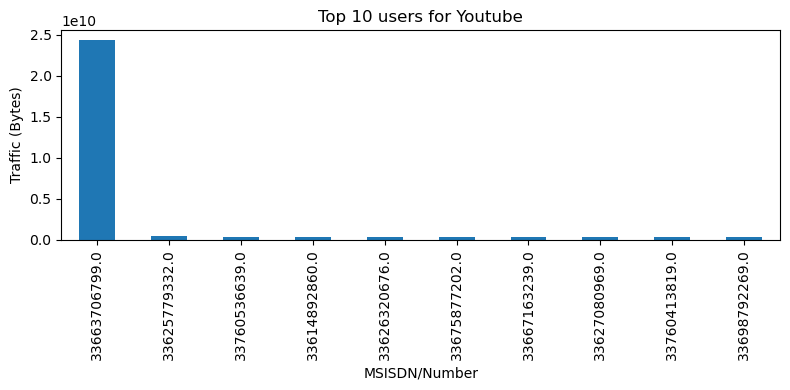

In [9]:
total_per_app = {}
for app in apps:
    col = f"{app.lower().replace(' ', '_')}_bytes"
    total_per_app[app] = app_user_totals[col].sum()

total_per_app_series = pd.Series(total_per_app).sort_values(ascending=False)
top3_apps = total_per_app_series.head(3)
print("\nTop 3 applications by total traffic (all users):")
print(top3_apps)

# Bar chart of total traffic for top 3 apps
plt.figure(figsize=(6,4))
top3_apps.plot(kind="bar")
plt.title("Top 3 Most Used Applications (Total Traffic Bytes)")
plt.ylabel("Total Traffic (Bytes)")
plt.tight_layout()
plt.show()

# For each top app, show top-10 users bar chart
for app in top3_apps.index:
    col = f"{app.lower().replace(' ', '_')}_bytes"
    top10 = app_user_totals.nlargest(10, col).set_index("MSISDN/Number")[col]
    plt.figure(figsize=(8,4))
    top10.plot(kind="bar")
    plt.title(f"Top 10 users for {app}")
    plt.ylabel("Traffic (Bytes)")
    plt.xlabel("MSISDN/Number")
    plt.tight_layout()
    plt.show()

### ELBOW METHOD FOR OPTIMAL K (1..10) & simple knee detection


Running Elbow method (k=1..10)...


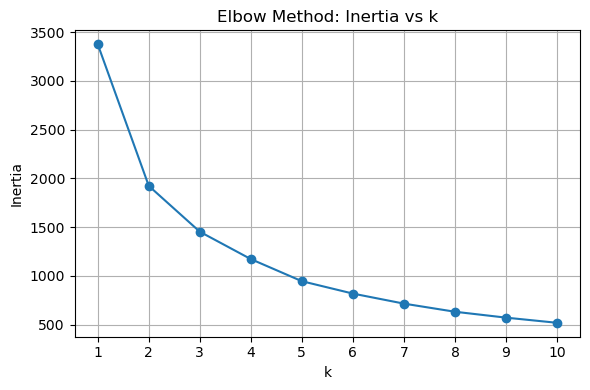

Suggested k by simple knee detection: 9 (visual check recommended)

Cluster centers for suggested k (original scale):
   sessions_frequency  total_session_duration_min  total_traffic_bytes  \
0            2.076560                    4.996148         2.845528e+09   
1            1.002878                    1.620991         1.465700e+09   
2            1.202104                    7.132318         1.637231e+09   
3            5.039163                    5.989735         8.793459e+09   
4            1.003365                    3.002035         1.412543e+09   
5            2.014648                    2.175415         3.057858e+09   
6            3.302628                    5.000847         5.081480e+09   
7            3.395915                   11.273459         4.863648e+09   
8            1.029254                    0.558745         1.435736e+09   

   avg_session_duration_min  
0                  2.426207  
1                  1.617677  
2                  6.257883  
3                  1.

In [10]:
print("\nRunning Elbow method (k=1..10)...")
inertias = []
K_range = range(1, 11)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    km.fit(X_norm)
    inertias.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(list(K_range), inertias, marker='o')
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("Elbow Method: Inertia vs k")
plt.xticks(list(K_range))
plt.grid(True)
plt.tight_layout()
plt.show()

# simple knee detection using second derivative (discrete)
diff1 = np.diff(inertias)
diff2 = np.diff(diff1)
if len(diff2) > 0:
    knee_index = np.argmax(-diff2) + 2  # +2 to map to k (since diff2[0] corresponds to k=3)
    suggested_k = knee_index if knee_index >= 1 else 3
else:
    suggested_k = 3

print(f"Suggested k by simple knee detection: {suggested_k} (visual check recommended)")

# If user wants, recompute kmeans with suggested_k and show centers
km_opt = KMeans(n_clusters=suggested_k, random_state=RANDOM_STATE, n_init=10)
agg["engagement_cluster_opt"] = km_opt.fit_predict(X_norm)
centers_opt = scaler.inverse_transform(km_opt.cluster_centers_)
print("\nCluster centers for suggested k (original scale):")
print(pd.DataFrame(centers_opt, columns=engagement_cols))




### Summary interpretation

In [11]:

print("\nSummary Interpretation:")
print("- Top users across metrics identify heavy-engagers (high sessions and traffic).")
print("- k=3 clustering roughly separates low/medium/high engagement groups (verify centers).")
print("- Cluster statistics (printed above) show per-cluster min/mean/max on raw metrics for targeting.")
print("- Top 3 applications (plotted) indicate where network resources and UX improvements will have most impact.")


Summary Interpretation:
- Top users across metrics identify heavy-engagers (high sessions and traffic).
- k=3 clustering roughly separates low/medium/high engagement groups (verify centers).
- Cluster statistics (printed above) show per-cluster min/mean/max on raw metrics for targeting.
- Top 3 applications (plotted) indicate where network resources and UX improvements will have most impact.


In [12]:
# Save DataFrame into CSV back for next use
df.to_csv("processed_data.csv", index=False)

print("✅ DataFrame saved as processed_data.csv for next use")

✅ DataFrame saved as processed_data.csv for next use
